In [5]:
!pip install sounddevice webrtcvad-wheels librosa

  Using cached sounddevice-0.5.2-py3-none-win_amd64.whl.metadata (1.6 kB)
Using cached sounddevice-0.5.2-py3-none-win_amd64.whl (363 kB)


In [1]:
import sounddevice as sd
import numpy as np
import webrtcvad
import librosa
import torch
import torch.nn.functional as F
from scipy.signal import resample

# --- Model definition (same as training) ---
class SimpleCNN(torch.nn.Module):
    def __init__(self, input_shape=(1, 13, 80), num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(2)
        self.dropout = torch.nn.Dropout(0.3)
        self.flatten_dim = self._get_flatten_size(input_shape)
        self.fc1 = torch.nn.Linear(self.flatten_dim, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)

    def _get_flatten_size(self, shape):
        with torch.no_grad():
            x = torch.zeros(1, *shape)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            return x.view(1, -1).shape[1]

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        return self.fc2(x)

# --- Load model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(input_shape=(1, 13, 80), num_classes=10).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# --- Label map (order must match training) ---
labels = ['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']
#labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

# --- VAD and audio settings ---
vad = webrtcvad.Vad(0)  # Aggressiveness
sr = 16000
chunk_duration = 30      # ms
chunk_size = int(sr * chunk_duration / 1000)
num_chunks = int(1000 / chunk_duration)  # to collect 1 second

def is_speech(frame_bytes):
    return vad.is_speech(frame_bytes, sample_rate=sr)

def get_mfcc(audio):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=1024, hop_length=128, win_length=400)
    if mfcc.shape[1] < 80:
        mfcc = np.pad(mfcc, ((0, 0), (0, 80 - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :80]
    return mfcc

# --- Stream handler ---
print("🎙️ Listening... Speak a keyword")

buffer = []

def callback(indata, frames, time, status):
    global buffer
    if status:
        print(status)

    audio = indata[:, 0]
    raw_bytes = (audio * 32768).astype(np.int16).tobytes()

    if is_speech(raw_bytes):
        buffer.extend(audio)
    else:
        if len(buffer) >= sr:  # at least 1 second of speech
            chunk = np.array(buffer[:sr])  # keep 1s
            mfcc = get_mfcc(chunk)
            x = torch.tensor(mfcc).unsqueeze(0).unsqueeze(0).float().to(device)  # (1, 1, 13, 80)
            with torch.no_grad():
                output = model(x)
                pred = torch.argmax(output, axis=1).item()
                print(f">>> Predicted: {labels[pred]}")
            buffer = []

# --- Start Stream ---
with sd.InputStream(channels=1, samplerate=sr, callback=callback, blocksize=chunk_size):
    while True:
        sd.sleep(1000)


C:\Users\USER\AppData\Local\Temp\ipykernel_18268\1458955591.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locat

🎙️ Listening... Speak a keyword
>>> Predicted: left
input overflow
>>> Predicted: left
>>> Predicted: right
>>> Predicted: no
>>> Predicted: down
>>> Predicted: no
>>> Predicted: go
>>> Predicted: on
>>> Predicted: off
>>> Predicted: stop
>>> Predicted: off
>>> Predicted: down
>>> Predicted: up
>>> Predicted: down
>>> Predicted: left
>>> Predicted: yes


KeyboardInterrupt: 

In [7]:
sd.default.device = (1, None)


Recording...
Done.


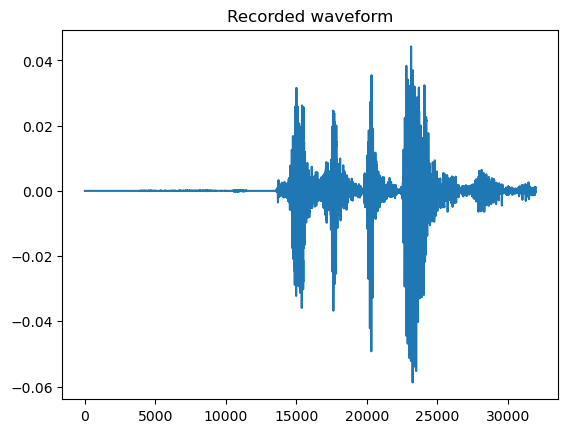

In [13]:
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt

duration = 2  # record for 1 second
sr = 16000

print("Recording...")
audio = sd.rec(int(sr * duration), samplerate=sr, channels=1)
sd.wait()
print("Done.")

plt.plot(audio)
plt.title("Recorded waveform")
plt.show()
